The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Training the Q-network


100%|█████████████████████████████████████| 10000/10000 [06:00<00:00, 27.76it/s]


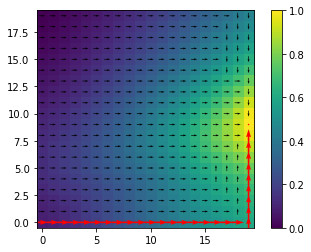

In [41]:
%load_ext autoreload
%autoreload 2

import os, sys, pdb, math, pickle, time

import matplotlib
import tensorflow as tf, numpy as np, matplotlib.pyplot as plt
from tqdm import tqdm

from utils import map_chunked, generate_problem, visualize_value_function


def Q_learning(Q_network, reward_fn, is_terminal_fn, X, U, Xp, gam):
    assert X.ndim == 2 and U.ndim == 2 and Xp.ndim == 2
    sdim, adim = X.shape[-1], U.shape[-1]

    @tf.function
    def loss():
        batch_n = int(1e4)
        ridx = tf.random.uniform([batch_n], 0, X.shape[0], dtype=tf.int32)
        X_, U_, Xp_ = [tf.gather(z, ridx) for z in [X, U, Xp]]

        U_all = tf.tile(
            tf.range(4, dtype=tf.float32)[None, :, None], (batch_n, 1, 1)
        )
        Xp_all = tf.tile(Xp_[:, None, :], (1, 4, 1))
        U_all = tf.reshape(U_all, (-1, 1))
        Xp_all = tf.reshape(Xp_all, (-1, sdim))
        input = tf.concat([Xp_all, U_all], -1)
        next_Q = tf.reduce_max(tf.reshape(Q_network(input), (-1, 4)), -1)
        input = tf.concat([X_, U_], -1)
        Q = tf.reshape(Q_network(input), [-1])

        ######### Your code starts here #########
        # compute the loss

        # given the current (Q) and the optimal next state Q function (Q_next), 
        # compute the Q-learning loss

        # make sure to account for the reward, the terminal state and the
        # discount factor gam
        
        mask = tf.cast((tf.cast(is_terminal_fn(X_),tf.int32) == 0),tf.float32)
        Q_start = reward_fn(X_,U_) + gam*(next_Q)*mask
        l = tf.reduce_mean((Q_start-Q)**2)
        
        ######### Your code ends here ###########

        # need to regularize the Q-value, because we're training its difference
        l = l + 1e-3 * tf.reduce_mean(Q ** 2)
        return l

    ######### Your code starts here #########
    # create the Adam optimizer with tensorflow keras
    # experiment with different learning rates [1e-4, 1e-3, 1e-2, 1e-1]
    
    opt = tf.keras.optimizers.Adam(learning_rate=1e-4) 

    ######### Your code ends here ###########

    print("Training the Q-network")
    for _ in tqdm(range(int(1e4))):
        ######### Your code starts here #########
        # apply a single step of gradient descent to the Q_network variables
        # take a look at the tf.keras.optimizers
        
        gs = opt.minimize(loss, Q_network.variables) # one step of GD

        ######### Your code ends here ###########


# Q-learning # #################################################################
def main():
    problem = generate_problem()
    n = problem["n"]
    sdim, adim = n * n, 1
    Ts = problem["Ts"]  # transistion matrices
    idx2pos = tf.convert_to_tensor(problem["idx2pos"], dtype=tf.float32)

    # sample state action triples
    samp_nb = int(1e5)
    try:
        # load state transitions from disk
        with open("state_transitions.pkl", "rb") as fp:
            temp = pickle.load(fp)
            X, U, Xp = [tf.convert_to_tensor(z, dtype=tf.float32) for z in temp]
    except FileNotFoundError:
        # if the state transistions do not exist, create them
        X = tf.random.uniform([samp_nb], 0, sdim, dtype=tf.int32)
        U = tf.random.uniform([samp_nb], 0, 4, dtype=tf.int32)
        x_list, u_list, xp_list = [], [], []
        print("Sampling state transitions")
        for i in tqdm(range(samp_nb)):
            x = X[i]
            u = U[i]
            ######### Your code starts here #########
            # x is the integer state index in the vectorized state shape: []
            # u is the integer action shape: []
            # compute xp, the integer next state shape: []
            
            # make use of the transition matrices and tf.random.categorical
            # tf.one_hot can be used to convert an integer state into a vector
            # with 1 in the place of that index

            # remember that transition matrices have a shape [sdim, sdim]
            # remember that tf.random.categorical takes in the log of
            # probabilities, not the probabilities themselves

            T = Ts[u]
            xp = tf.random.categorical(tf.math.log([T[x]]),1)
            
            ######### Your code ends here ###########

            # convert integer states to a 2D representation using idx2pos
            xp = tf.reshape(xp, [])
            x_list.append(idx2pos[x])
            u_list.append(tf.reshape(tf.cast(u, tf.float32), [1]))
            xp_list.append(idx2pos[xp])
        X, U, Xp = tf.stack(x_list), tf.stack(u_list), tf.stack(xp_list)
        with open("state_transitions.pkl", "wb") as fp:
            pickle.dump((X.numpy(), U.numpy(), Xp.numpy()), fp)

    # define the reward ####################################
    reward_vec = np.zeros([sdim])
    reward_vec[problem["pos2idx"][19, 9]] = 1.0
    reward_vec = tf.convert_to_tensor(reward_vec, dtype=tf.float32)

    def reward_fn(X, U):
        return tf.cast(
            tf.reduce_all(X == tf.constant([19.0, 9.0]), -1), tf.float32
        )

    def is_terminal_fn(X):
        return tf.reduce_all(X == tf.constant([19.0, 9.0]), -1)

    ######### Your code starts here #########
    # create the deep Q-network
    # it needs to take in 2 state + 1 action input (3 inputs)
    # it needs to output a single value (batch x 1 output) - the Q-value
    # it should be 3 layers deep with
    
    inputs = tf.keras.layers.Input(shape=[3])
    out = tf.keras.layers.Dense(64, activation="tanh")(inputs) 
    out = tf.keras.layers.Dense(64, activation="tanh")(out) 
    out = tf.keras.layers.Dense(1)(out)
    Q_network = tf.keras.Model(inputs=[inputs], outputs=out)  
    
    ######### Your code ends here ###########

    # train the Q-network ##################################
    gam = 0.95
    Q_learning(Q_network, reward_fn, is_terminal_fn, X, U, Xp, gam)
    ########################################################

    # visualize the Q-network ##############################
    # sample all states
    y, x = [
        tf.reshape(tf.convert_to_tensor(z, dtype=tf.float32), [-1])
        for z in np.meshgrid(np.arange(n), np.arange(n))
    ]
    X_ = tf.range(n * n)
    X_ = tf.tile(
        tf.stack([tf.gather(x, X_), tf.gather(y, X_)], -1)[:, None, :],
        (1, 4, 1),
    )

    # compute optimal value of the Q-network at each state (max over actions)
    # and compute the value function from the Q-network
    U_ = tf.tile(tf.range(4, dtype=tf.float32)[None, :, None], (sdim, 1, 1))
    X_, U_ = tf.reshape(X_, (-1, 2)), tf.reshape(U_, (-1, 1))
    q_input = tf.concat([X_, U_], -1)
    V = tf.reduce_max(tf.reshape(Q_network(q_input), (-1, 4)), -1)

    # visualize the result
    plt.figure(120)
    visualize_value_function(V.numpy().reshape((n, n)))
    plt.colorbar()
    plt.show()
    ########################################################


if __name__ == "__main__":
    main()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Training the Q-network


100%|█████████████████████████████████████| 10000/10000 [05:53<00:00, 28.30it/s]


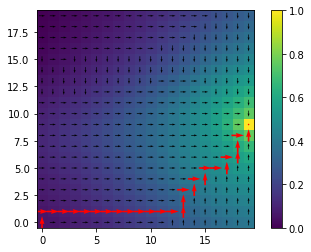

In [43]:
%load_ext autoreload
%autoreload 2

import os, sys, pdb, math, pickle, time

import matplotlib
import tensorflow as tf, numpy as np, matplotlib.pyplot as plt
from tqdm import tqdm

from utils import map_chunked, generate_problem, visualize_value_function


def Q_learning(Q_network, reward_fn, is_terminal_fn, X, U, Xp, gam):
    assert X.ndim == 2 and U.ndim == 2 and Xp.ndim == 2
    sdim, adim = X.shape[-1], U.shape[-1]

    @tf.function
    def loss():
        batch_n = int(1e4)
        ridx = tf.random.uniform([batch_n], 0, X.shape[0], dtype=tf.int32)
        X_, U_, Xp_ = [tf.gather(z, ridx) for z in [X, U, Xp]]

        U_all = tf.tile(
            tf.range(4, dtype=tf.float32)[None, :, None], (batch_n, 1, 1)
        )
        Xp_all = tf.tile(Xp_[:, None, :], (1, 4, 1))
        U_all = tf.reshape(U_all, (-1, 1))
        Xp_all = tf.reshape(Xp_all, (-1, sdim))
        input = tf.concat([Xp_all, U_all], -1)
        next_Q = tf.reduce_max(tf.reshape(Q_network(input), (-1, 4)), -1)
        input = tf.concat([X_, U_], -1)
        Q = tf.reshape(Q_network(input), [-1])

        ######### Your code starts here #########
        # compute the loss

        # given the current (Q) and the optimal next state Q function (Q_next), 
        # compute the Q-learning loss

        # make sure to account for the reward, the terminal state and the
        # discount factor gam
        
        mask = tf.cast((tf.cast(is_terminal_fn(X_),tf.int32) == 0),tf.float32)
        #mask = tf.cast(tf.bitwise.invert(tf.cast(is_terminal_fn(X_),tf.int32)),tf.float32)

        Q_start = reward_fn(X_,U_) + gam*(next_Q)*mask
        l = tf.reduce_mean((Q_start-Q)**2)
        
        ######### Your code ends here ###########

        # need to regularize the Q-value, because we're training its difference
        l = l + 1e-3 * tf.reduce_mean(Q ** 2)
        return l

    ######### Your code starts here #########
    # create the Adam optimizer with tensorflow keras
    # experiment with different learning rates [1e-4, 1e-3, 1e-2, 1e-1]
    
    opt = tf.keras.optimizers.Adam(learning_rate=1e-2) 

    ######### Your code ends here ###########

    print("Training the Q-network")
    for _ in tqdm(range(int(1e4))):
        ######### Your code starts here #########
        # apply a single step of gradient descent to the Q_network variables
        # take a look at the tf.keras.optimizers
        
        gs = opt.minimize(loss, Q_network.variables) # one step of GD

        ######### Your code ends here ###########


# Q-learning # #################################################################
def main():
    problem = generate_problem()
    n = problem["n"]
    sdim, adim = n * n, 1
    Ts = problem["Ts"]  # transistion matrices
    idx2pos = tf.convert_to_tensor(problem["idx2pos"], dtype=tf.float32)

    # sample state action triples
    samp_nb = int(1e5)
    try:
        # load state transitions from disk
        with open("state_transitions.pkl", "rb") as fp:
            temp = pickle.load(fp)
            X, U, Xp = [tf.convert_to_tensor(z, dtype=tf.float32) for z in temp]
    except FileNotFoundError:
        # if the state transistions do not exist, create them
        X = tf.random.uniform([samp_nb], 0, sdim, dtype=tf.int32)
        U = tf.random.uniform([samp_nb], 0, 4, dtype=tf.int32)
        x_list, u_list, xp_list = [], [], []
        print("Sampling state transitions")
        for i in tqdm(range(samp_nb)):
            x = X[i]
            u = U[i]
            ######### Your code starts here #########
            # x is the integer state index in the vectorized state shape: []
            # u is the integer action shape: []
            # compute xp, the integer next state shape: []
            
            # make use of the transition matrices and tf.random.categorical
            # tf.one_hot can be used to convert an integer state into a vector
            # with 1 in the place of that index

            # remember that transition matrices have a shape [sdim, sdim]
            # remember that tf.random.categorical takes in the log of
            # probabilities, not the probabilities themselves

            T = Ts[u]
            xp = tf.random.categorical(tf.math.log([T[x]]),1)
            
            ######### Your code ends here ###########

            # convert integer states to a 2D representation using idx2pos
            xp = tf.reshape(xp, [])
            x_list.append(idx2pos[x])
            u_list.append(tf.reshape(tf.cast(u, tf.float32), [1]))
            xp_list.append(idx2pos[xp])
        X, U, Xp = tf.stack(x_list), tf.stack(u_list), tf.stack(xp_list)
        with open("state_transitions.pkl", "wb") as fp:
            pickle.dump((X.numpy(), U.numpy(), Xp.numpy()), fp)

    # define the reward ####################################
    reward_vec = np.zeros([sdim])
    reward_vec[problem["pos2idx"][19, 9]] = 1.0
    reward_vec = tf.convert_to_tensor(reward_vec, dtype=tf.float32)

    def reward_fn(X, U):
        return tf.cast(
            tf.reduce_all(X == tf.constant([19.0, 9.0]), -1), tf.float32
        )

    def is_terminal_fn(X):
        return tf.reduce_all(X == tf.constant([19.0, 9.0]), -1)

    ######### Your code starts here #########
    # create the deep Q-network
    # it needs to take in 2 state + 1 action input (3 inputs)
    # it needs to output a single value (batch x 1 output) - the Q-value
    # it should be 3 layers deep with
    
    inputs = tf.keras.layers.Input(shape=[3])
    out = tf.keras.layers.Dense(64, activation="tanh")(inputs) 
    out = tf.keras.layers.Dense(64, activation="tanh")(out) 
    out = tf.keras.layers.Dense(1)(out)
    Q_network = tf.keras.Model(inputs=[inputs], outputs=out)  
    
    ######### Your code ends here ###########

    # train the Q-network ##################################
    gam = 0.95
    Q_learning(Q_network, reward_fn, is_terminal_fn, X, U, Xp, gam)
    ########################################################

    # visualize the Q-network ##############################
    # sample all states
    y, x = [
        tf.reshape(tf.convert_to_tensor(z, dtype=tf.float32), [-1])
        for z in np.meshgrid(np.arange(n), np.arange(n))
    ]
    X_ = tf.range(n * n)
    X_ = tf.tile(
        tf.stack([tf.gather(x, X_), tf.gather(y, X_)], -1)[:, None, :],
        (1, 4, 1),
    )

    # compute optimal value of the Q-network at each state (max over actions)
    # and compute the value function from the Q-network
    U_ = tf.tile(tf.range(4, dtype=tf.float32)[None, :, None], (sdim, 1, 1))
    X_, U_ = tf.reshape(X_, (-1, 2)), tf.reshape(U_, (-1, 1))
    q_input = tf.concat([X_, U_], -1)
    V = tf.reduce_max(tf.reshape(Q_network(q_input), (-1, 4)), -1)

    # visualize the result
    plt.figure(120)
    visualize_value_function(V.numpy().reshape((n, n)))
    plt.colorbar()
    plt.show()
    ########################################################


if __name__ == "__main__":
    main()




The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Training the Q-network


100%|█████████████████████████████████████| 10000/10000 [05:47<00:00, 28.80it/s]


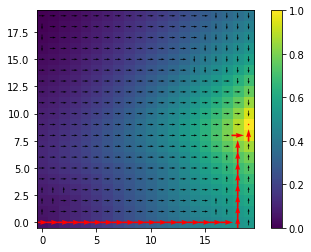

In [44]:
%load_ext autoreload
%autoreload 2

import os, sys, pdb, math, pickle, time

import matplotlib
import tensorflow as tf, numpy as np, matplotlib.pyplot as plt
from tqdm import tqdm

from utils import map_chunked, generate_problem, visualize_value_function


def Q_learning(Q_network, reward_fn, is_terminal_fn, X, U, Xp, gam):
    assert X.ndim == 2 and U.ndim == 2 and Xp.ndim == 2
    sdim, adim = X.shape[-1], U.shape[-1]

    @tf.function
    def loss():
        batch_n = int(1e4)
        ridx = tf.random.uniform([batch_n], 0, X.shape[0], dtype=tf.int32)
        X_, U_, Xp_ = [tf.gather(z, ridx) for z in [X, U, Xp]]

        U_all = tf.tile(
            tf.range(4, dtype=tf.float32)[None, :, None], (batch_n, 1, 1)
        )
        Xp_all = tf.tile(Xp_[:, None, :], (1, 4, 1))
        U_all = tf.reshape(U_all, (-1, 1))
        Xp_all = tf.reshape(Xp_all, (-1, sdim))
        input = tf.concat([Xp_all, U_all], -1)
        next_Q = tf.reduce_max(tf.reshape(Q_network(input), (-1, 4)), -1)
        input = tf.concat([X_, U_], -1)
        Q = tf.reshape(Q_network(input), [-1])

        ######### Your code starts here #########
        # compute the loss

        # given the current (Q) and the optimal next state Q function (Q_next), 
        # compute the Q-learning loss

        # make sure to account for the reward, the terminal state and the
        # discount factor gam
        
        mask = tf.cast((tf.cast(is_terminal_fn(X_),tf.int32) == 0),tf.float32)
        #mask = tf.cast(tf.bitwise.invert(tf.cast(is_terminal_fn(X_),tf.int32)),tf.float32)

        Q_start = reward_fn(X_,U_) + gam*(next_Q)*mask
        l = tf.reduce_mean((Q_start-Q)**2)
        
        ######### Your code ends here ###########

        # need to regularize the Q-value, because we're training its difference
        l = l + 1e-3 * tf.reduce_mean(Q ** 2)
        return l

    ######### Your code starts here #########
    # create the Adam optimizer with tensorflow keras
    # experiment with different learning rates [1e-4, 1e-3, 1e-2, 1e-1]
    
    opt = tf.keras.optimizers.Adam(learning_rate=1e-3) 

    ######### Your code ends here ###########

    print("Training the Q-network")
    for _ in tqdm(range(int(1e4))):
        ######### Your code starts here #########
        # apply a single step of gradient descent to the Q_network variables
        # take a look at the tf.keras.optimizers
        
        gs = opt.minimize(loss, Q_network.variables) # one step of GD

        ######### Your code ends here ###########


# Q-learning # #################################################################
def main():
    problem = generate_problem()
    n = problem["n"]
    sdim, adim = n * n, 1
    Ts = problem["Ts"]  # transistion matrices
    idx2pos = tf.convert_to_tensor(problem["idx2pos"], dtype=tf.float32)

    # sample state action triples
    samp_nb = int(1e5)
    try:
        # load state transitions from disk
        with open("state_transitions.pkl", "rb") as fp:
            temp = pickle.load(fp)
            X, U, Xp = [tf.convert_to_tensor(z, dtype=tf.float32) for z in temp]
    except FileNotFoundError:
        # if the state transistions do not exist, create them
        X = tf.random.uniform([samp_nb], 0, sdim, dtype=tf.int32)
        U = tf.random.uniform([samp_nb], 0, 4, dtype=tf.int32)
        x_list, u_list, xp_list = [], [], []
        print("Sampling state transitions")
        for i in tqdm(range(samp_nb)):
            x = X[i]
            u = U[i]
            ######### Your code starts here #########
            # x is the integer state index in the vectorized state shape: []
            # u is the integer action shape: []
            # compute xp, the integer next state shape: []
            
            # make use of the transition matrices and tf.random.categorical
            # tf.one_hot can be used to convert an integer state into a vector
            # with 1 in the place of that index

            # remember that transition matrices have a shape [sdim, sdim]
            # remember that tf.random.categorical takes in the log of
            # probabilities, not the probabilities themselves

            T = Ts[u]
            xp = tf.random.categorical(tf.math.log([T[x]]),1)
            
            ######### Your code ends here ###########

            # convert integer states to a 2D representation using idx2pos
            xp = tf.reshape(xp, [])
            x_list.append(idx2pos[x])
            u_list.append(tf.reshape(tf.cast(u, tf.float32), [1]))
            xp_list.append(idx2pos[xp])
        X, U, Xp = tf.stack(x_list), tf.stack(u_list), tf.stack(xp_list)
        with open("state_transitions.pkl", "wb") as fp:
            pickle.dump((X.numpy(), U.numpy(), Xp.numpy()), fp)

    # define the reward ####################################
    reward_vec = np.zeros([sdim])
    reward_vec[problem["pos2idx"][19, 9]] = 1.0
    reward_vec = tf.convert_to_tensor(reward_vec, dtype=tf.float32)

    def reward_fn(X, U):
        return tf.cast(
            tf.reduce_all(X == tf.constant([19.0, 9.0]), -1), tf.float32
        )

    def is_terminal_fn(X):
        return tf.reduce_all(X == tf.constant([19.0, 9.0]), -1)

    ######### Your code starts here #########
    # create the deep Q-network
    # it needs to take in 2 state + 1 action input (3 inputs)
    # it needs to output a single value (batch x 1 output) - the Q-value
    # it should be 3 layers deep with
    
    inputs = tf.keras.layers.Input(shape=[3])
    out = tf.keras.layers.Dense(64, activation="tanh")(inputs) 
    out = tf.keras.layers.Dense(64, activation="tanh")(out) 
    out = tf.keras.layers.Dense(1)(out)
    Q_network = tf.keras.Model(inputs=[inputs], outputs=out)  
    
    ######### Your code ends here ###########

    # train the Q-network ##################################
    gam = 0.95
    Q_learning(Q_network, reward_fn, is_terminal_fn, X, U, Xp, gam)
    ########################################################

    # visualize the Q-network ##############################
    # sample all states
    y, x = [
        tf.reshape(tf.convert_to_tensor(z, dtype=tf.float32), [-1])
        for z in np.meshgrid(np.arange(n), np.arange(n))
    ]
    X_ = tf.range(n * n)
    X_ = tf.tile(
        tf.stack([tf.gather(x, X_), tf.gather(y, X_)], -1)[:, None, :],
        (1, 4, 1),
    )

    # compute optimal value of the Q-network at each state (max over actions)
    # and compute the value function from the Q-network
    U_ = tf.tile(tf.range(4, dtype=tf.float32)[None, :, None], (sdim, 1, 1))
    X_, U_ = tf.reshape(X_, (-1, 2)), tf.reshape(U_, (-1, 1))
    q_input = tf.concat([X_, U_], -1)
    V = tf.reduce_max(tf.reshape(Q_network(q_input), (-1, 4)), -1)

    # visualize the result
    plt.figure(120)
    visualize_value_function(V.numpy().reshape((n, n)))
    plt.colorbar()
    plt.show()
    ########################################################


if __name__ == "__main__":
    main()





The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Training the Q-network


100%|█████████████████████████████████████| 10000/10000 [05:45<00:00, 28.90it/s]


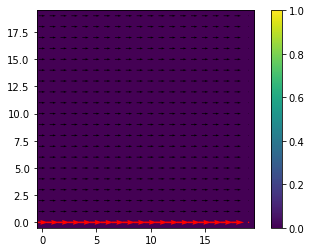

In [45]:
%load_ext autoreload
%autoreload 2

import os, sys, pdb, math, pickle, time

import matplotlib
import tensorflow as tf, numpy as np, matplotlib.pyplot as plt
from tqdm import tqdm

from utils import map_chunked, generate_problem, visualize_value_function


def Q_learning(Q_network, reward_fn, is_terminal_fn, X, U, Xp, gam):
    assert X.ndim == 2 and U.ndim == 2 and Xp.ndim == 2
    sdim, adim = X.shape[-1], U.shape[-1]

    @tf.function
    def loss():
        batch_n = int(1e4)
        ridx = tf.random.uniform([batch_n], 0, X.shape[0], dtype=tf.int32)
        X_, U_, Xp_ = [tf.gather(z, ridx) for z in [X, U, Xp]]

        U_all = tf.tile(
            tf.range(4, dtype=tf.float32)[None, :, None], (batch_n, 1, 1)
        )
        Xp_all = tf.tile(Xp_[:, None, :], (1, 4, 1))
        U_all = tf.reshape(U_all, (-1, 1))
        Xp_all = tf.reshape(Xp_all, (-1, sdim))
        input = tf.concat([Xp_all, U_all], -1)
        next_Q = tf.reduce_max(tf.reshape(Q_network(input), (-1, 4)), -1)
        input = tf.concat([X_, U_], -1)
        Q = tf.reshape(Q_network(input), [-1])

        ######### Your code starts here #########
        # compute the loss

        # given the current (Q) and the optimal next state Q function (Q_next), 
        # compute the Q-learning loss

        # make sure to account for the reward, the terminal state and the
        # discount factor gam
        
        mask = tf.cast((tf.cast(is_terminal_fn(X_),tf.int32) == 0),tf.float32)
        #mask = tf.cast(tf.bitwise.invert(tf.cast(is_terminal_fn(X_),tf.int32)),tf.float32)

        Q_start = reward_fn(X_,U_) + gam*(next_Q)*mask
        l = tf.reduce_mean((Q_start-Q)**2)
        
        ######### Your code ends here ###########

        # need to regularize the Q-value, because we're training its difference
        l = l + 1e-3 * tf.reduce_mean(Q ** 2)
        return l

    ######### Your code starts here #########
    # create the Adam optimizer with tensorflow keras
    # experiment with different learning rates [1e-4, 1e-3, 1e-2, 1e-1]
    
    opt = tf.keras.optimizers.Adam(learning_rate=1e-1) 

    ######### Your code ends here ###########

    print("Training the Q-network")
    for _ in tqdm(range(int(1e4))):
        ######### Your code starts here #########
        # apply a single step of gradient descent to the Q_network variables
        # take a look at the tf.keras.optimizers
        
        gs = opt.minimize(loss, Q_network.variables) # one step of GD

        ######### Your code ends here ###########


# Q-learning # #################################################################
def main():
    problem = generate_problem()
    n = problem["n"]
    sdim, adim = n * n, 1
    Ts = problem["Ts"]  # transistion matrices
    idx2pos = tf.convert_to_tensor(problem["idx2pos"], dtype=tf.float32)

    # sample state action triples
    samp_nb = int(1e5)
    try:
        # load state transitions from disk
        with open("state_transitions.pkl", "rb") as fp:
            temp = pickle.load(fp)
            X, U, Xp = [tf.convert_to_tensor(z, dtype=tf.float32) for z in temp]
    except FileNotFoundError:
        # if the state transistions do not exist, create them
        X = tf.random.uniform([samp_nb], 0, sdim, dtype=tf.int32)
        U = tf.random.uniform([samp_nb], 0, 4, dtype=tf.int32)
        x_list, u_list, xp_list = [], [], []
        print("Sampling state transitions")
        for i in tqdm(range(samp_nb)):
            x = X[i]
            u = U[i]
            ######### Your code starts here #########
            # x is the integer state index in the vectorized state shape: []
            # u is the integer action shape: []
            # compute xp, the integer next state shape: []
            
            # make use of the transition matrices and tf.random.categorical
            # tf.one_hot can be used to convert an integer state into a vector
            # with 1 in the place of that index

            # remember that transition matrices have a shape [sdim, sdim]
            # remember that tf.random.categorical takes in the log of
            # probabilities, not the probabilities themselves

            T = Ts[u]
            xp = tf.random.categorical(tf.math.log([T[x]]),1)
            
            ######### Your code ends here ###########

            # convert integer states to a 2D representation using idx2pos
            xp = tf.reshape(xp, [])
            x_list.append(idx2pos[x])
            u_list.append(tf.reshape(tf.cast(u, tf.float32), [1]))
            xp_list.append(idx2pos[xp])
        X, U, Xp = tf.stack(x_list), tf.stack(u_list), tf.stack(xp_list)
        with open("state_transitions.pkl", "wb") as fp:
            pickle.dump((X.numpy(), U.numpy(), Xp.numpy()), fp)

    # define the reward ####################################
    reward_vec = np.zeros([sdim])
    reward_vec[problem["pos2idx"][19, 9]] = 1.0
    reward_vec = tf.convert_to_tensor(reward_vec, dtype=tf.float32)

    def reward_fn(X, U):
        return tf.cast(
            tf.reduce_all(X == tf.constant([19.0, 9.0]), -1), tf.float32
        )

    def is_terminal_fn(X):
        return tf.reduce_all(X == tf.constant([19.0, 9.0]), -1)

    ######### Your code starts here #########
    # create the deep Q-network
    # it needs to take in 2 state + 1 action input (3 inputs)
    # it needs to output a single value (batch x 1 output) - the Q-value
    # it should be 3 layers deep with
    
    inputs = tf.keras.layers.Input(shape=[3])
    out = tf.keras.layers.Dense(64, activation="tanh")(inputs) 
    out = tf.keras.layers.Dense(64, activation="tanh")(out) 
    out = tf.keras.layers.Dense(1)(out)
    Q_network = tf.keras.Model(inputs=[inputs], outputs=out)  
    
    ######### Your code ends here ###########

    # train the Q-network ##################################
    gam = 0.95
    Q_learning(Q_network, reward_fn, is_terminal_fn, X, U, Xp, gam)
    ########################################################

    # visualize the Q-network ##############################
    # sample all states
    y, x = [
        tf.reshape(tf.convert_to_tensor(z, dtype=tf.float32), [-1])
        for z in np.meshgrid(np.arange(n), np.arange(n))
    ]
    X_ = tf.range(n * n)
    X_ = tf.tile(
        tf.stack([tf.gather(x, X_), tf.gather(y, X_)], -1)[:, None, :],
        (1, 4, 1),
    )

    # compute optimal value of the Q-network at each state (max over actions)
    # and compute the value function from the Q-network
    U_ = tf.tile(tf.range(4, dtype=tf.float32)[None, :, None], (sdim, 1, 1))
    X_, U_ = tf.reshape(X_, (-1, 2)), tf.reshape(U_, (-1, 1))
    q_input = tf.concat([X_, U_], -1)
    V = tf.reduce_max(tf.reshape(Q_network(q_input), (-1, 4)), -1)

    # visualize the result
    plt.figure(120)
    visualize_value_function(V.numpy().reshape((n, n)))
    plt.colorbar()
    plt.show()
    ########################################################


if __name__ == "__main__":
    main()
